In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
# from category_encoders import TargetEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa



/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If 

In [2]:
# Load the data with outliers 
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
train_data.tail()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,fico_avg
1015107,15000.0,36,10.49,487.47,B3,MORTGAGE,60000.0,Not Verified,Fully Paid,debt_consolidation,CO,26.40,24,0,48654.0,36.1,42,Individual,2.0,682.0
1015108,36400.0,60,14.49,856.24,C4,RENT,95000.0,Verified,Charged Off,credit_card,CA,21.50,11,0,55723.0,79.8,24,Individual,6.0,722.0
1015109,18000.0,60,9.49,377.95,B2,OWN,130000.0,Not Verified,Fully Paid,home_improvement,TX,20.59,17,0,23833.0,34.0,39,Individual,3.0,737.0
1015110,29400.0,60,13.99,683.94,C3,MORTGAGE,180792.0,Not Verified,Fully Paid,debt_consolidation,CA,22.03,16,0,77480.0,85.2,32,Individual,3.0,707.0
1015111,24000.0,60,14.49,564.56,C4,RENT,110000.0,Not Verified,Charged Off,debt_consolidation,FL,18.30,10,1,17641.0,68.1,31,Individual,2.0,662.0


In [5]:
len(test_data.columns), len(train_data.columns)

(20, 20)

In [6]:
train_data.shape, test_data.shape

((1015112, 20), (127128, 20))

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015112 entries, 0 to 1015111
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1015112 non-null  float64
 1   term (months)        1015112 non-null  int64  
 2   int_rate             1015112 non-null  float64
 3   installment          1015112 non-null  float64
 4   sub_grade            1015112 non-null  object 
 5   home_ownership       1015112 non-null  object 
 6   annual_inc           1015112 non-null  float64
 7   verification_status  1015112 non-null  object 
 8   loan_status          1015112 non-null  object 
 9   purpose              1015112 non-null  object 
 10  addr_state           1015112 non-null  object 
 11  dti                  1015112 non-null  float64
 12  open_acc             1015112 non-null  int64  
 13  pub_rec              1015112 non-null  int64  
 14  revol_bal            1015112 non-null  float64
 15

In [8]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
train_data['Label'] = train_data[target_column].map(class_mapping)
test_data['Label'] = test_data[target_column].map(class_mapping)

In [9]:
print(train_data.shape)
train_data['Label'].value_counts(normalize=True) * 100


(1015112, 21)


Label
0    80.31104
1    19.68896
Name: proportion, dtype: float64

In [10]:
print(test_data.shape)
test_data['Label'].value_counts(normalize=True) * 100

(127128, 21)


Label
0    80.52514
1    19.47486
Name: proportion, dtype: float64

 Leaving 'term (months)' as a number 

In [11]:
train_data = train_data.drop('loan_status', axis = 1)
test_data = test_data.drop('loan_status', axis = 1)

In [12]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'application_type']

In [13]:
for column in categorical_columns:
    unique_values = train_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'sub_grade' has 35 unique values.
Column 'home_ownership' has 4 unique values.
Column 'verification_status' has 3 unique values.
Column 'purpose' has 13 unique values.
Column 'addr_state' has 51 unique values.
Column 'application_type' has 2 unique values.


TODO : since home_ownership, verification_status, purpose and application_type have less than neary 10 categories we will use one hot encodign on them
target encoding for sub_grade and addr_state


In [14]:
cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type', 'addr_state', 'sub_grade', 'purpose']

# cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type']
# cat_target_encoding = ['addr_state', 'sub_grade', 'purpose']



In [15]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,fico_avg,Label
0,3600.0,36,13.99,123.03,C4,MORTGAGE,55000.0,Not Verified,debt_consolidation,PA,5.91,7,0,2765.0,29.7,13,Individual,1.0,677.0,0
1,24700.0,36,11.99,820.28,C1,MORTGAGE,65000.0,Not Verified,small_business,SD,16.06,22,0,21470.0,19.2,38,Individual,4.0,717.0,0
2,20000.0,60,10.78,432.66,B4,MORTGAGE,63000.0,Not Verified,home_improvement,IL,10.78,6,0,7869.0,56.2,18,Joint App,5.0,697.0,0
3,10400.0,60,22.45,289.91,F1,MORTGAGE,104433.0,Source Verified,major_purchase,PA,25.37,12,0,21929.0,64.5,35,Individual,6.0,697.0,0
4,11950.0,36,13.44,405.18,C3,RENT,34000.0,Source Verified,debt_consolidation,GA,10.20,5,0,8822.0,68.4,6,Individual,0.0,692.0,0


In [16]:
# encoder = TargetEncoder(cols=cat_target_encoding)

# encoder.fit(train_data[cat_target_encoding], train_data['Label'])


In [17]:
# X_train_encoded = encoder.transform(train_data[cat_target_encoding])
# X_test_encoded = encoder.transform(test_data[cat_target_encoding])

# # Replace original categorical columns with encoded columns in X_train and X_test
# X_train_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]
# X_test_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]

# # Drop original categorical columns from X_train and X_test
# train_data.drop(columns=cat_target_encoding, inplace=True)
# test_data.drop(columns=cat_target_encoding, inplace=True)

# # Concatenate encoded columns with remaining features
# train_data = pd.concat([train_data, X_train_encoded], axis=1)
# test_data = pd.concat([test_data, X_test_encoded], axis=1)

In [18]:
combined_df = pd.concat([train_data, test_data], axis=0)
combined_df.reset_index(drop=True, inplace=True)

custom_prefixes = {col: col + "_" for col in cat_columns_ohe}

encoded_combined_df = pd.get_dummies(combined_df, columns=cat_columns_ohe, drop_first=True, prefix=custom_prefixes)

encoded_combined_df.reset_index(drop=True, inplace=True)


In [19]:
train_data = encoded_combined_df.iloc[:len(train_data)]
train_data.reset_index(drop=True, inplace=True)
test_data = encoded_combined_df.iloc[len(train_data):]
test_data.reset_index(drop=True, inplace=True)


In [20]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__Joint App,addr_state__AL,addr_state__AR,addr_state__AZ,addr_state__CA,addr_state__CO,addr_state__CT,addr_state__DC,addr_state__DE,addr_state__FL,addr_state__GA,addr_state__HI,addr_state__IA,addr_state__ID,addr_state__IL,addr_state__IN,addr_state__KS,addr_state__KY,addr_state__LA,addr_state__MA,addr_state__MD,addr_state__ME,addr_state__MI,addr_state__MN,addr_state__MO,addr_state__MS,addr_state__MT,addr_state__NC,addr_state__ND,addr_state__NE,addr_state__NH,addr_state__NJ,addr_state__NM,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding
0,3600.0,36,13.99,123.03,55000.0,5.91,7,0,2765.0,29.7,13,1.0,677.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,24700.0,36,11.99,820.28,65000.0,16.06,22,0,21470.0,19.2,38,4.0,717.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,20000.0,60,10.78,432.66,63000.0,10.78,6,0,7869.0,56.2,18,5.0,697.0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,10400.0,60,22.45,289.91,104433.0,25.37,12,0,21929.0,64.5,35,6.0,697.0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [21]:
numerical_columns = train_data.select_dtypes(include=['number']).columns.tolist()
# numerical_columns = [col for col in numerical_columns if col not in ['Label', 'addr_state_encoded', 'sub_grade_encoded', 'purpose_encoded']]
numerical_columns = [col for col in numerical_columns if col not in ['Label']]
numerical_columns

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'fico_avg']

In [22]:
train_numerical_data = train_data[numerical_columns]
test_numerical_data = test_data[numerical_columns]

train_data = train_data.drop(columns=numerical_columns)
test_data = test_data.drop(columns=numerical_columns)

scaler = RobustScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
robust_train_data = pd.concat([train_data, scaled_train_df], axis=1)
robust_test_data = pd.concat([test_data, scaled_test_df], axis=1)

 
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
standard_train_data = pd.concat([train_data, scaled_train_df], axis=1)
standard_test_data = pd.concat([test_data, scaled_test_df], axis=1)


scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
minmax_train_data = pd.concat([train_data, scaled_train_df], axis=1)
minmax_test_data = pd.concat([test_data, scaled_test_df], axis=1)

In [23]:
robust_train_data.head()



,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__Joint App,addr_state__AL,addr_state__AR,addr_state__AZ,addr_state__CA,addr_state__CO,addr_state__CT,addr_state__DC,addr_state__DE,addr_state__FL,addr_state__GA,addr_state__HI,addr_state__IA,addr_state__ID,addr_state__IL,addr_state__IN,addr_state__KS,addr_state__KY,addr_state__LA,addr_state__MA,addr_state__MD,addr_state__ME,addr_state__MI,addr_state__MN,addr_state__MO,addr_state__MS,addr_state__MT,addr_state__NC,addr_state__ND,addr_state__NE,addr_state__NH,addr_state__NJ,addr_state__NM,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg
0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,-0.710417,0.0,0.203915,-0.798716,-0.232558,-0.988245,-0.666667,0.0,-0.638185,-0.668524,-0.666667,0.000000,-0.250
1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,1.047917,0.0,-0.122349,1.363769,0.000000,-0.136020,1.833333,0.0,0.760111,-0.961003,1.000000,1.000000,0.750
2,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.656250,24.0,-0.319739,0.161585,-0.046512,-0.579345,-0.833333,0.0,-0.256635,0.069638,-0.333333,1.333333,0.250
3,0,False,False,False,True,False,False,False,False,False,False,Fals

In [24]:
robust_train_data = robust_train_data[robust_train_data['dti'] >= 0]
standard_train_data = standard_train_data[standard_train_data['dti'] >= 0]
minmax_train_data = minmax_train_data[minmax_train_data['dti'] >= 0]


In [25]:
# train_data = train_data.drop('issue_d', axis = 1)
# test_data = test_data.drop('issue_d', axis = 1)

In [26]:
boolean_columns = train_data.select_dtypes(include=[bool]).columns

robust_train_data[boolean_columns] = robust_train_data[boolean_columns].astype(int)
robust_test_data[boolean_columns] = robust_test_data[boolean_columns].astype(int)

standard_train_data[boolean_columns] = standard_train_data[boolean_columns].astype(int)
standard_test_data[boolean_columns] = standard_test_data[boolean_columns].astype(int)

minmax_train_data[boolean_columns] = minmax_train_data[boolean_columns].astype(int)
minmax_test_data[boolean_columns] = minmax_test_data[boolean_columns].astype(int)





In [27]:
robust_train_data.head()



,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__Joint App,addr_state__AL,addr_state__AR,addr_state__AZ,addr_state__CA,addr_state__CO,addr_state__CT,addr_state__DC,addr_state__DE,addr_state__FL,addr_state__GA,addr_state__HI,addr_state__IA,addr_state__ID,addr_state__IL,addr_state__IN,addr_state__KS,addr_state__KY,addr_state__LA,addr_state__MA,addr_state__MD,addr_state__ME,addr_state__MI,addr_state__MN,addr_state__MO,addr_state__MS,addr_state__MT,addr_state__NC,addr_state__ND,addr_state__NE,addr_state__NH,addr_state__NJ,addr_state__NM,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.143750,24.0,1.584013,-0.281146,0.917047,0.645676,0.166667,0.0,0.794423,0.300836,0.800000,1.666667,0.250
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.343750,0.0,-0.205546,-0.362311,-0.534884,1.437448,-0.500000,0.0,-0.319055,-0.406685,-0.333333,0.000000,0.375
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.893750,0.0,0.022838,-1.034209,-0.023256,1.450042,1.000000,0.0,1.982956,0.376045,0.066667,1.000000,0.375
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.322917,0.0,-1.019576,1.480911,0.627907,0.329135,0.833333,0.0,3.005532,0.300836,0.066667,0.333333,0.875
12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.210417,0.0,-0.856444,-0.254257,-0.116279,0.399664,-0.666667,0.0,-0.267624,0.158774,-0.933333,-0.333333,0.250


In [28]:
# numerical_cols = numerical_columns.append('Label')
numerical_cols = numerical_columns + ["Label"]
numerical_cols

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'fico_avg',
 'Label']

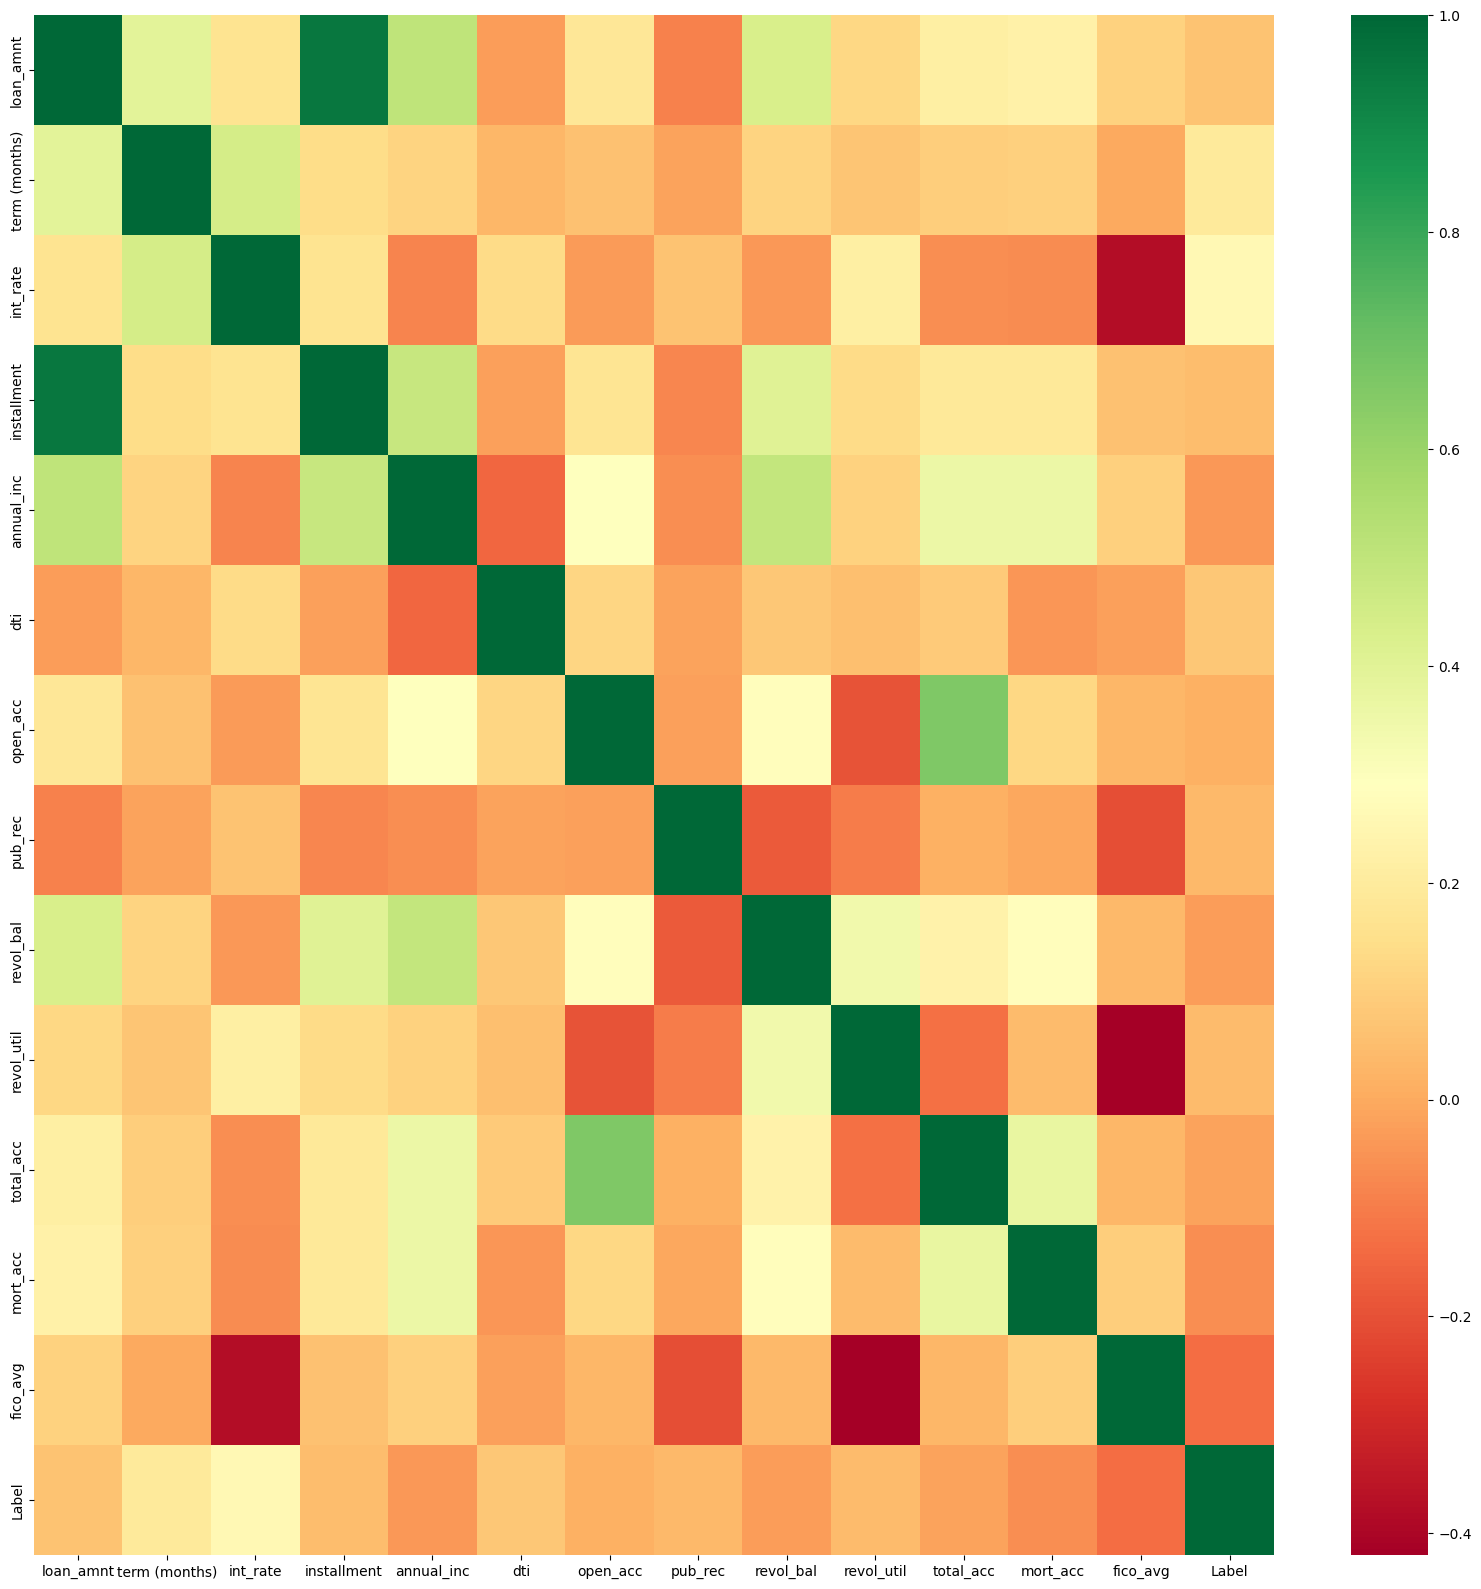

In [29]:
plt.figure(figsize = (20, 20))
sns.heatmap(robust_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

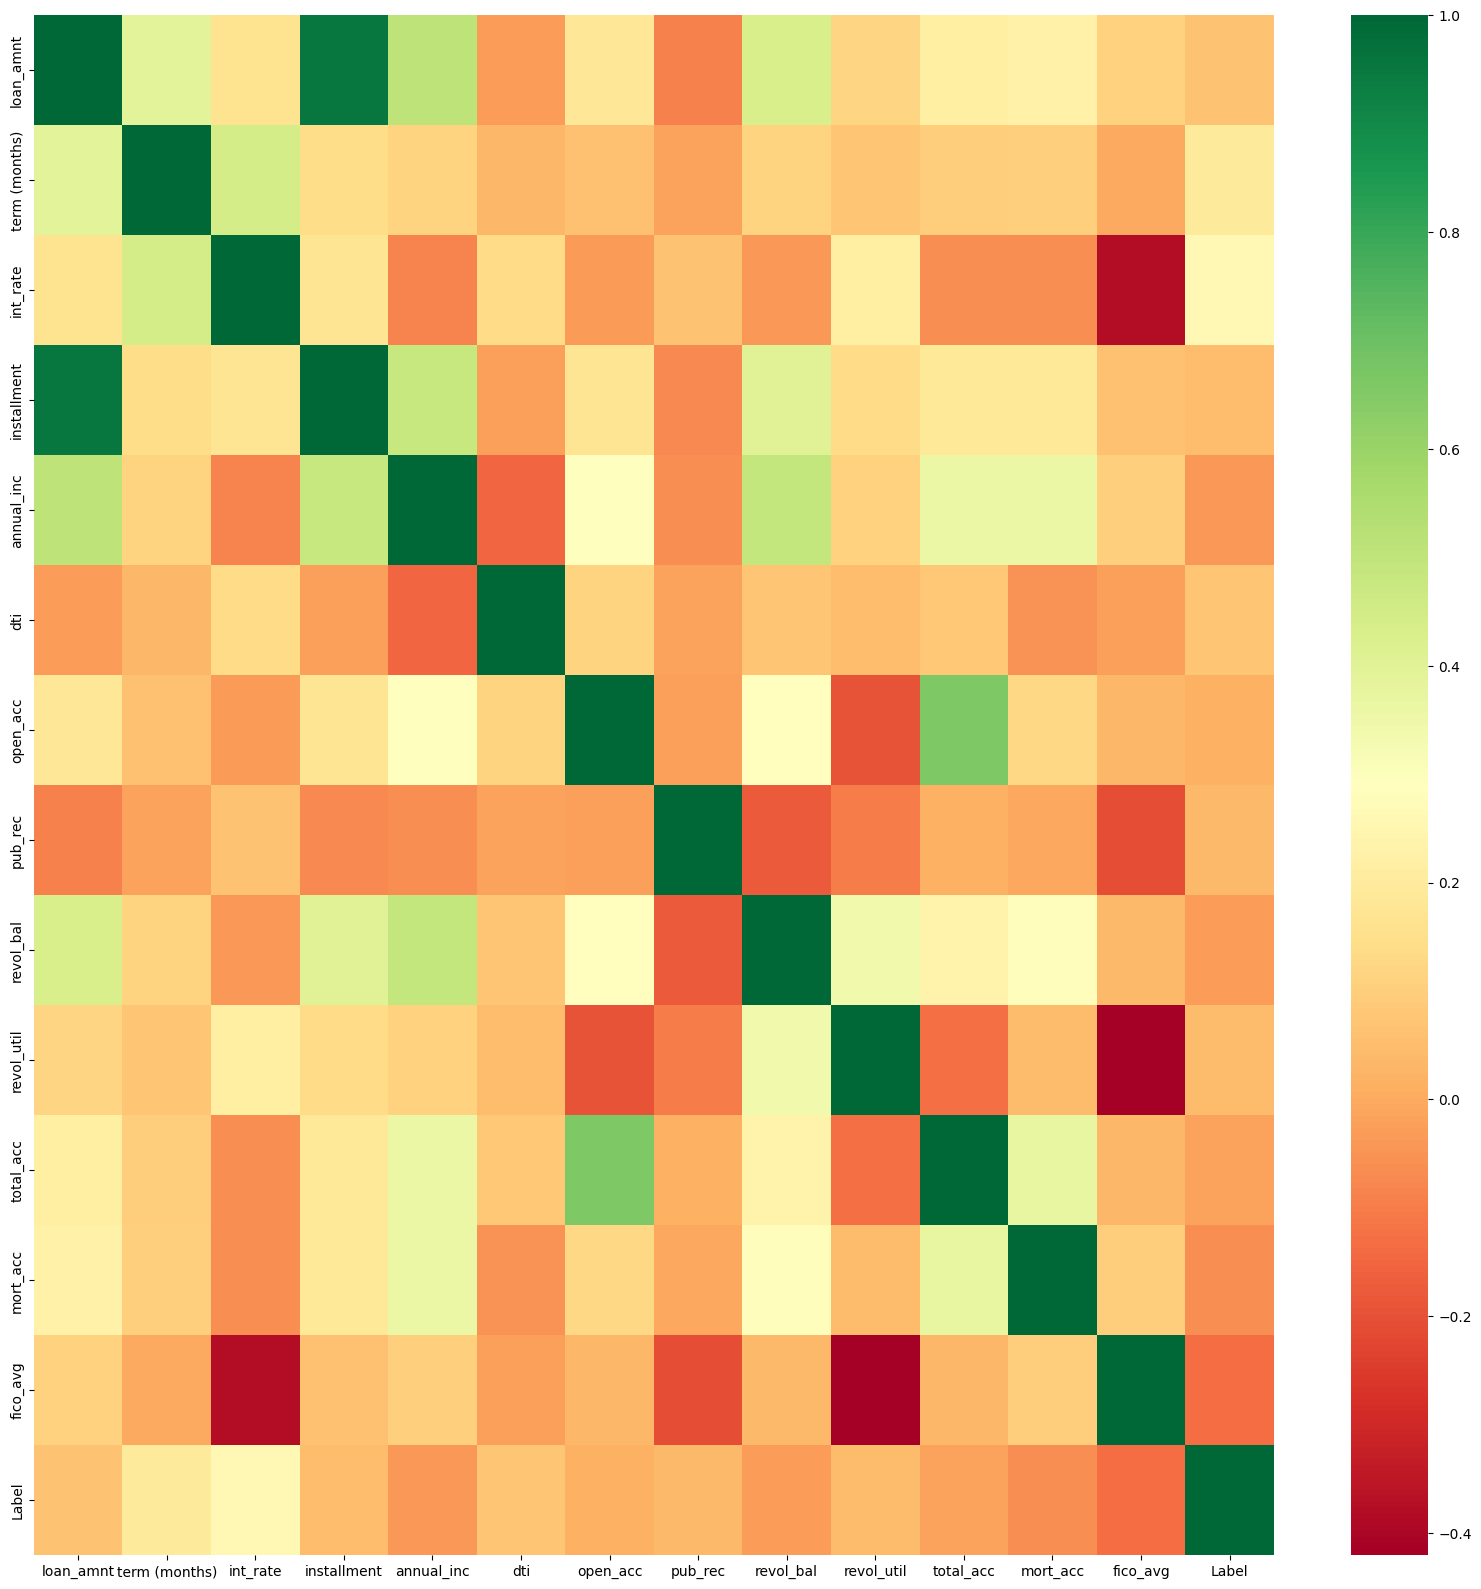

In [30]:
plt.figure(figsize = (20, 20))
sns.heatmap(standard_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

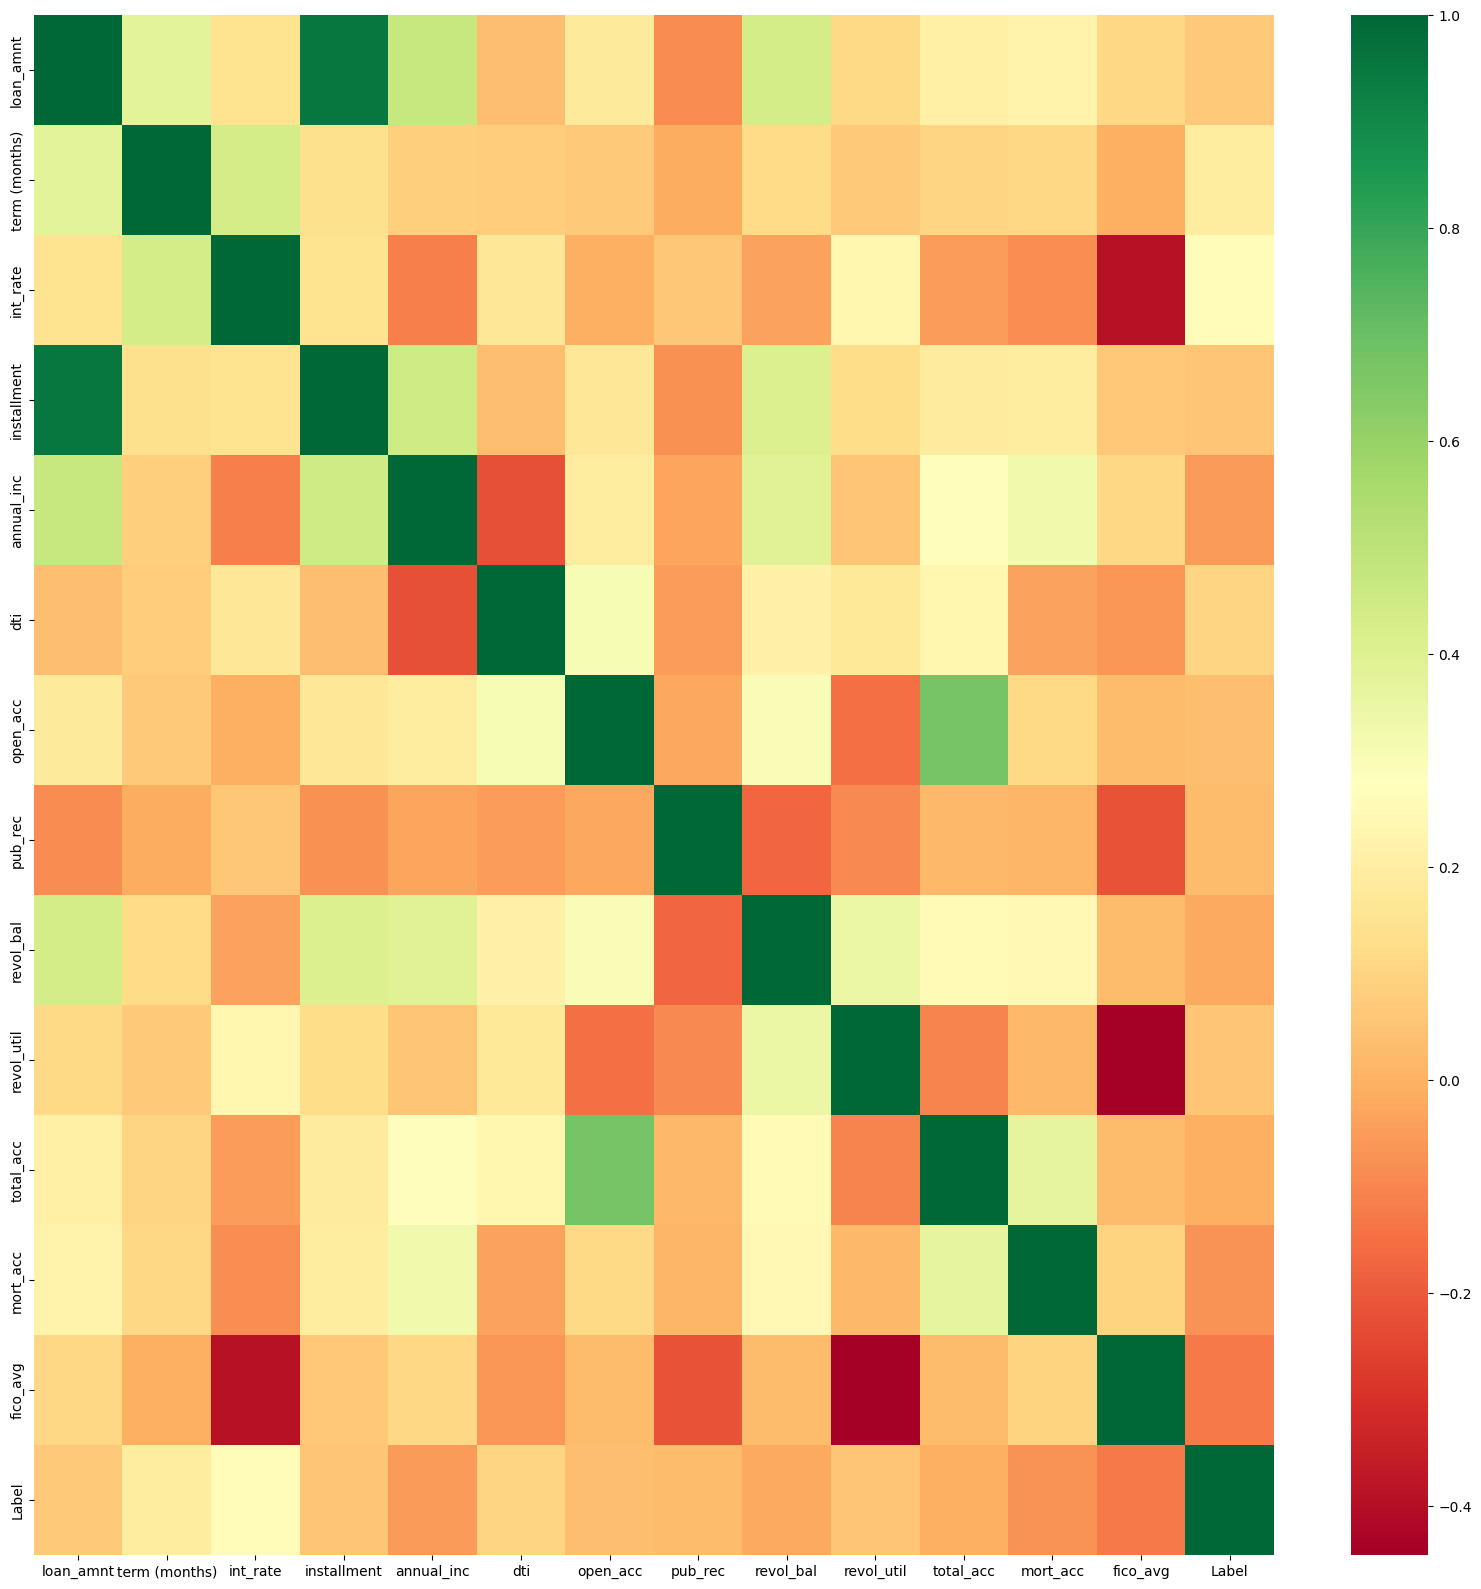

In [31]:
plt.figure(figsize = (20, 20))
sns.heatmap(minmax_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

In [32]:
X_train_robust  = robust_train_data.drop("Label", axis = 1)
y_train_robust = robust_train_data["Label"]
X_test_robust = robust_test_data.drop("Label", axis = 1)
y_test_robust = robust_test_data["Label"]

X_train_standard = standard_train_data.drop("Label", axis=1)
y_train_standard = standard_train_data["Label"]
X_test_standard = standard_test_data.drop("Label", axis=1)
y_test_standard = standard_test_data["Label"]

X_train_minmax = minmax_train_data.drop("Label", axis=1)
y_train_minmax = minmax_train_data["Label"]
X_test_minmax = minmax_test_data.drop("Label", axis=1)
y_test_minmax = minmax_test_data["Label"]

In [33]:
X_train_robust.shape

(507842, 115)

In [34]:
# from sklearn.preprocessing import PowerTransformer

# # Select only the specified numerical columns
# # selected_numerical_columns = [col for col in numerical_columns if col not in ['Label', 'mort_acc', 'pub_rec']]
# selected_numerical_columns = [col for col in numerical_columns if col not in ['Label']]

# # Apply Box-Cox Transform after handling zero values
# train_data_transformed = X_train[selected_numerical_columns].apply(lambda x: x + 0.000001 if (x <= 0).any() else x)
# pt = PowerTransformer(method='box-cox')
# train_data_transformed[selected_numerical_columns] = pt.fit_transform(train_data_transformed)

# # Replace original numerical columns in X_train with their normalized versions
# X_train[selected_numerical_columns] = train_data_transformed[selected_numerical_columns]


In [35]:
# pd.DataFrame({'cols':selected_numerical_columns,'box_cox_lambdas':pt.lambdas_})

In [36]:
# X_train.columns[X_train.isna().any()].tolist()

In [37]:
# X_test.shape,y_test.shape, X_train.shape, y_train.shape

In [38]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

The SGDClassifier estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the loss hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting loss = 'log'.

In [39]:
naive_model = SGDClassifier(loss='log_loss')


In [40]:
naive_model.fit(X_train_robust, y_train_robust)

SGDClassifier(loss='log_loss')

In [41]:
y_train_pred_robust = naive_model.predict(X_train_robust)
y_pred_robust = naive_model.predict(X_test_robust)

In [42]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 77.32%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.783806       0.556063  0.773203       0.669934   
recall          0.973088       0.111578  0.773203       0.542333   
f1-score        0.868251       0.185861  0.773203       0.527056   
support    390014.000000  117828.000000  0.773203  507842.000000   

            weighted avg  
precision       0.730966  
recall          0.773203  
f1-score        0.709925  
support    507842.000000  
_______________________________________________
Confusion Matrix: 
 [[379518  10496]
 [104681  13147]]

Test Result:
Accuracy Score: 80.50%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.816874      0.496501  0.804992       0.656687       0.754482
recall          0.976810      0.094555  0.80499

In [43]:
naive_model.fit(X_train_standard, y_train_standard)

SGDClassifier(loss='log_loss')

In [44]:
y_train_pred_standard = naive_model.predict(X_train_standard)
y_pred_standard = naive_model.predict(X_test_standard)

In [45]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)


Train Result:
Accuracy Score: 77.06%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.787093       0.532972  0.770607       0.660032   
recall          0.960465       0.147964  0.770607       0.554214   
f1-score        0.865179       0.231624  0.770607       0.548402   
support    374755.000000  114271.000000  0.770607  489026.000000   

            weighted avg  
precision       0.727712  
recall          0.770607  
f1-score        0.717136  
support    489026.000000  
_______________________________________________
Confusion Matrix: 
 [[359939  14816]
 [ 97363  16908]]

Test Result:
Accuracy Score: 80.18%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.820122      0.466697  0.801798       0.643409       0.751293
recall          0.965664      0.124243  0.80179

In [46]:
naive_model.fit(X_train_minmax, y_train_minmax)

SGDClassifier(loss='log_loss')

In [47]:
y_train_pred_minmax = naive_model.predict(X_train_minmax)
y_pred_minmax = naive_model.predict(X_test_minmax)

In [48]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)


Train Result:
Accuracy Score: 80.56%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.810058       0.567831  0.805605  6.889447e-01  7.623663e-01
recall          0.990106       0.053026  0.805605  5.215659e-01  8.056047e-01
f1-score        0.891078       0.096994  0.805605  4.940361e-01  7.347313e-01
support    815247.000000  199865.000000  0.805605  1.015112e+06  1.015112e+06
_______________________________________________
Confusion Matrix: 
 [[807181   8066]
 [189267  10598]]

Test Result:
Accuracy Score: 80.57%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.814763      0.507188  0.805676       0.660976       0.754864
recall          0.981919      0.076945  0.805676       0.529432       0.805676
f1-score        0.890565      0.133619  0.805676      

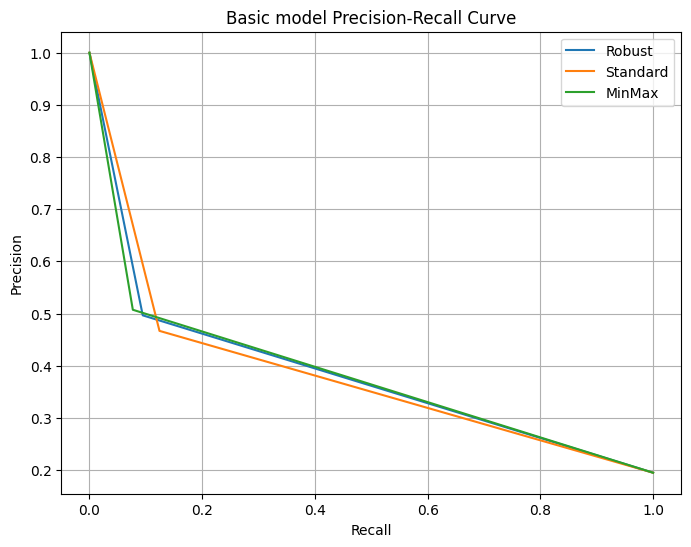

In [49]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_pred_robust, y_pred_standard, y_pred_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Basic model Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=1, warm_start=True, class_weight='balanced')

kf = StratifiedKFold(n_splits=5, shuffle=False)


In [51]:
param_grid_sgdlogreg = {
    'alpha': [10**-5, 10**-2, 10**1],
    'penalty': ['l1', 'l2']
}

In [52]:
grid_sgdlogreg_robust = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)

grid_sgdlogreg_standard = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)


grid_sgdlogreg_minmax = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)

In [53]:
grid_sgdlogreg_robust.fit(X_train_robust, y_train_robust)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [54]:
grid_sgdlogreg_robust.best_score_

0.7037975218720836

In [55]:
grid_sgdlogreg_robust.best_params_

{'alpha': 10, 'penalty': 'l2'}

In [56]:
grid_sgdlogreg_standard.fit(X_train_standard, y_train_standard)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [57]:
grid_sgdlogreg_standard.best_score_

0.6800924791206336

In [58]:
grid_sgdlogreg_standard.best_params_

{'alpha': 0.01, 'penalty': 'l1'}

In [59]:
grid_sgdlogreg_minmax.fit(X_train_minmax, y_train_minmax)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [60]:
grid_sgdlogreg_minmax.best_score_

0.7040026482759985

In [61]:
grid_sgdlogreg_minmax.best_params_

{'alpha': 0.01, 'penalty': 'l1'}

In [62]:
y_train_pred_robust = grid_sgdlogreg_robust.predict(X_train_robust)
y_pred_robust = grid_sgdlogreg_robust.predict(X_test_robust)

In [63]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 69.64%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.818077       0.367431  0.696386       0.592754   
recall          0.777577       0.427640  0.696386       0.602609   
f1-score        0.797313       0.395256  0.696386       0.596284   
support    390014.000000  117828.000000  0.696386  507842.000000   

            weighted avg  
precision       0.713519  
recall          0.696386  
f1-score        0.704029  
support    507842.000000  
_______________________________________________
Confusion Matrix: 
 [[303266  86748]
 [ 67440  50388]]

Test Result:
Accuracy Score: 69.45%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.836438      0.284788   0.69452       0.560613       0.729005
recall          0.771505      0.376202   0.6945

In [64]:
y_train_pred_standard = grid_sgdlogreg_standard.predict(X_train_standard)
y_pred_standard = grid_sgdlogreg_standard.predict(X_test_standard)

In [65]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)

Train Result:
Accuracy Score: 65.44%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.848732       0.358957  0.654409       0.603845   
recall          0.668106       0.609490  0.654409       0.638798   
f1-score        0.747664       0.451818  0.654409       0.599741   
support    374755.000000  114271.000000  0.654409  489026.000000   

            weighted avg  
precision       0.734286  
recall          0.654409  
f1-score        0.678534  
support    489026.000000  
_______________________________________________
Confusion Matrix: 
 [[250376 124379]
 [ 44624  69647]]

Test Result:
Accuracy Score: 67.98%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.869020      0.316996  0.679779       0.593008       0.761514
recall          0.709231      0.558001  0.67977

In [66]:
y_train_pred_minmax = grid_sgdlogreg_minmax.predict(X_train_minmax)
y_pred_minmax = grid_sgdlogreg_minmax.predict(X_test_minmax)

In [67]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)

Train Result:
Accuracy Score: 67.56%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.870102       0.319550  0.675628  5.948261e-01  7.617042e-01
recall          0.700715       0.573297  0.675628  6.370061e-01  6.756279e-01
f1-score        0.776276       0.410366  0.675628  5.933210e-01  7.042321e-01
support    815247.000000  199865.000000  0.675628  1.015112e+06  1.015112e+06
_______________________________________________
Confusion Matrix: 
 [[571256 243991]
 [ 85283 114582]]

Test Result:
Accuracy Score: 64.59%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.873668      0.298980  0.645932       0.586324       0.761748
recall          0.655016      0.608369  0.645932       0.631693       0.645932
f1-score        0.748705      0.400926  0.645932      

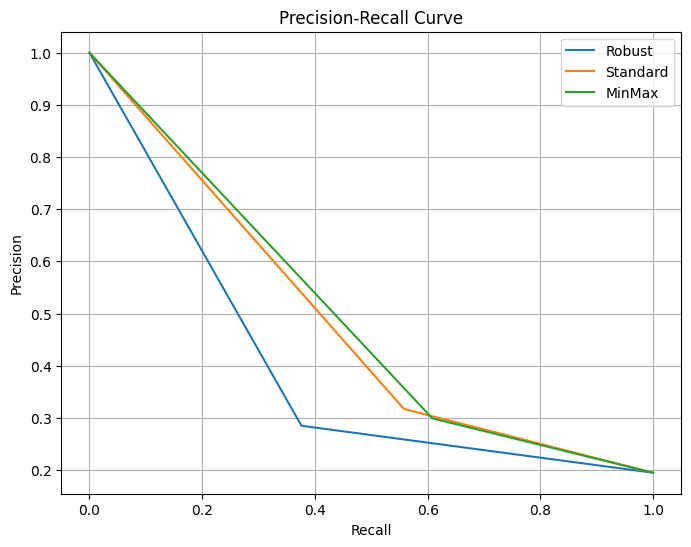

In [68]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_pred_robust, y_pred_standard, y_pred_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [69]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

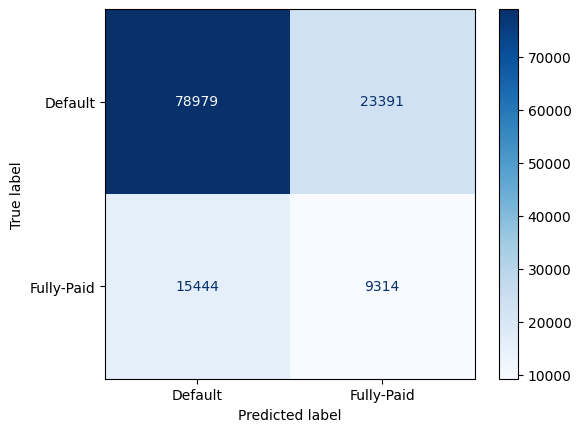

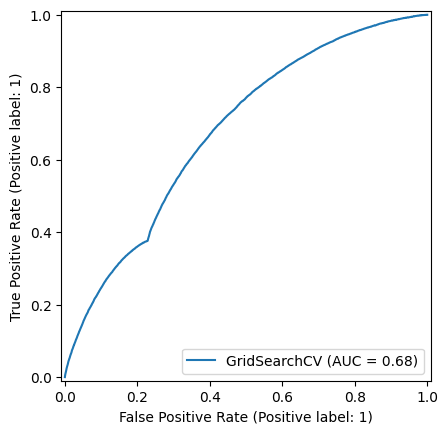

In [70]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_robust, X_test_robust, y_test_robust)

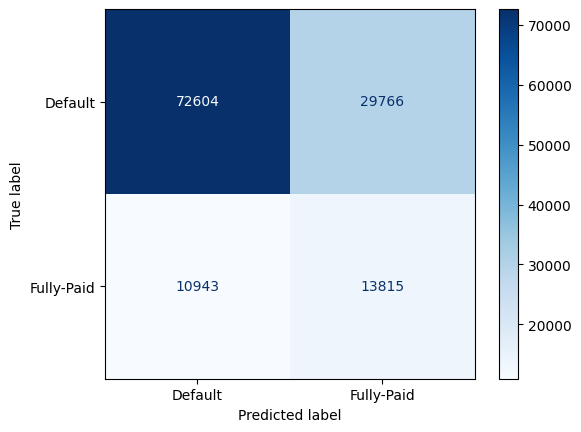

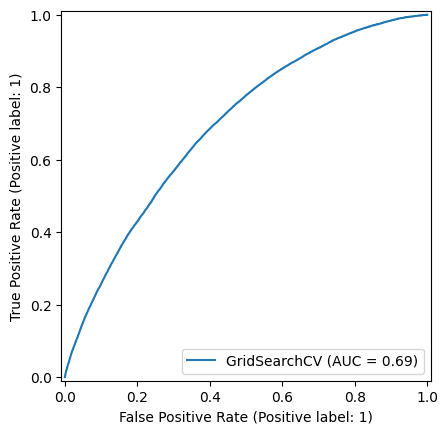

In [71]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_standard, X_test_standard, y_test_standard, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_standard, X_test_standard, y_test_robust)

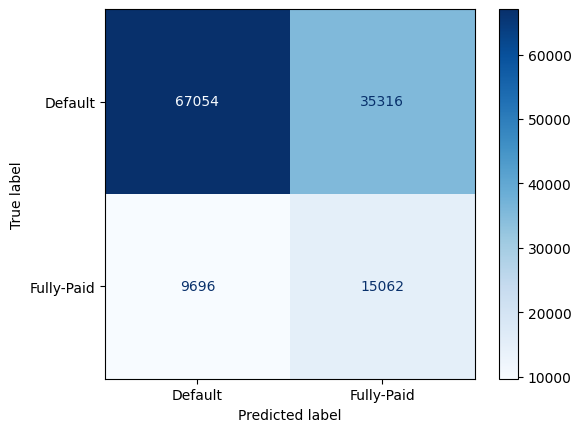

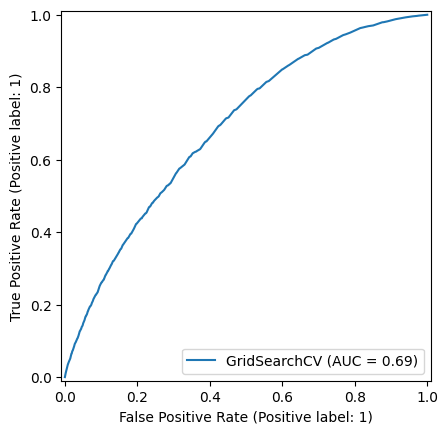

In [72]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax)

## With undersampling

In [73]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [74]:
rus = RandomUnderSampler(random_state=42)

In [75]:
X_under_robust, y_under_robust = rus.fit_resample(X_train_robust, y_train_robust)
X_under_minmax, y_under_minmax = rus.fit_resample(X_train_minmax, y_train_minmax)
X_under_standard, y_under_standard = rus.fit_resample(X_train_standard, y_train_standard)

In [76]:
print('Fully Paid:', y_under_robust.value_counts()[0], '/', round(y_under_robust.value_counts()[0]/len(y_under_robust) * 100,2), '% of the dataset')
print('Charged Off:', y_under_robust.value_counts()[1], '/',round(y_under_robust.value_counts()[1]/len(y_under_robust) * 100,2), '% of the dataset')




Fully Paid: 117828 / 50.0 % of the dataset
Charged Off: 117828 / 50.0 % of the dataset


In [77]:
param_grid_sgdlogreg = {
    'sgdclassifier__alpha': [0.00001, 0.001, 10],
    'sgdclassifier__penalty': ['l1', 'l2'],
}

In [78]:
pipeline = make_pipeline(RandomUnderSampler(random_state=42),
                       SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=1, warm_start=True, class_weight='balanced'))



In [79]:
grid_sgdlogreg_robust = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

grid_sgdlogreg_standard = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)


grid_sgdlogreg_minmax = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

In [80]:
grid_sgdlogreg_robust.fit(X_train_robust, y_train_robust)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=1)

In [81]:
grid_sgdlogreg_robust.best_score_

0.4561685355859944

In [82]:
grid_sgdlogreg_robust.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l2'}

In [83]:
y_train_pred_robust = grid_sgdlogreg_robust.predict(X_train_robust)
y_pred_robust = grid_sgdlogreg_robust.predict(X_test_robust)

In [84]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 63.19%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.862032       0.348057  0.631945       0.605045   
recall          0.619978       0.671555  0.631945       0.645766   
f1-score        0.721238       0.458487  0.631945       0.589862   
support    390014.000000  117828.000000  0.631945  507842.000000   

            weighted avg  
precision       0.742781  
recall          0.631945  
f1-score        0.660275  
support    507842.000000  
_______________________________________________
Confusion Matrix: 
 [[241800 148214]
 [ 38700  79128]]

Test Result:
Accuracy Score: 68.58%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.872796      0.325039  0.685781       0.598918       0.766121
recall          0.713822      0.569836  0.68578

In [85]:
grid_sgdlogreg_standard.fit(X_train_standard, y_train_standard)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=1)

In [86]:
grid_sgdlogreg_standard.best_score_

0.45810036620002653

In [87]:
grid_sgdlogreg_standard.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l2'}

In [88]:
y_train_pred_standard = grid_sgdlogreg_standard.predict(X_train_standard)
y_pred_standard = grid_sgdlogreg_standard.predict(X_test_standard)

In [89]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)

Train Result:
Accuracy Score: 63.82%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.858856       0.353179  0.638191       0.606018   
recall          0.631677       0.659555  0.638191       0.645616   
f1-score        0.727954       0.460024  0.638191       0.593989   
support    374755.000000  114271.000000  0.638191  489026.000000   

            weighted avg  
precision       0.740694  
recall          0.638191  
f1-score        0.665346  
support    489026.000000  
_______________________________________________
Confusion Matrix: 
 [[236724 138031]
 [ 38903  75368]]

Test Result:
Accuracy Score: 68.96%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.871355      0.326703  0.689573       0.599029       0.765285
recall          0.720934      0.559900  0.68957

In [ ]:
grid_sgdlogreg_minmax.fit(X_train_minmax, y_train_minmax)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
grid_sgdlogreg_minmax.best_score_

In [ ]:
grid_sgdlogreg_minmax.best_params_

In [ ]:
y_train_pred_minmax = grid_sgdlogreg_minmax.predict(X_train_minmax)
y_pred_minmax = grid_sgdlogreg_minmax.predict(X_test_minmax)

In [ ]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_pred_robust, y_pred_standard, y_pred_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_robust, X_test_robust, y_test_robust)

In [ ]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_standard, X_test_standard, y_test_standard, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_standard, X_test_standard, y_test_robust)

In [ ]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax)

# ANN - TODO

In [ ]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['f1_score'], label='f1_score')
    plt.plot(r.history['val_f1_score'], label='f1_score')
    plt.title('f1 score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[tfa.metrics.F1Score((name='f1_score',num_classes=num_labels))])
    return model

In [ ]:
num_columns = X_train_robust.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train_robust, y_train_robust,
    validation_data=(X_test_robust, y_test_robust),
    epochs=20,
    batch_size=32
)